In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

In [37]:
data_file_name = "output_file.csv"

In [38]:
# Veriyi data frame nesnesi olarak içeri aktarıyoruz
base_df = pd.read_csv(data_file_name, encoding='utf-8')
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46234 entries, 0 to 46233
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Yıl                46234 non-null  int64  
 1   Model              46234 non-null  int64  
 2   Renk               46234 non-null  int64  
 3   Boya-değişen       46234 non-null  float64
 4   Çekiş              46234 non-null  float64
 5   Arka Tampon        46234 non-null  float64
 6   Sağ Ön Çamurluk    46234 non-null  float64
 7   Sol Ön Çamurluk    46234 non-null  float64
 8   Kilometre          46234 non-null  int64  
 9   Fiyat              46234 non-null  int64  
 10  Marka              46234 non-null  int64  
 11  Yakıt Tipi         46234 non-null  float64
 12  Vites Tipi         46234 non-null  float64
 13  Kasa Tipi          46234 non-null  float64
 14  Ön Tampon          46234 non-null  float64
 15  Arka Kaput         46234 non-null  float64
 16  Sol Arka Kapı      462

In [39]:
useful_df = base_df.drop(['_id'], axis=1)

In [40]:
groups = useful_df.groupby("Marka")

cleaned_data = []

# Remove outliers from each group and add them to the cleaned dataset
for name, group in groups:
    Q1 = group["Fiyat"].quantile(0.25)
    Q3 = group["Fiyat"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.1 * IQR
    upper_bound = Q3 + 1.1 * IQR
    cleaned_group = group[(group["Fiyat"] >= lower_bound) & (group["Fiyat"] <= upper_bound)]
    cleaned_data.append(cleaned_group)


cleaned_df = pd.concat(cleaned_data)

# Equalize the numbers of data in each group

max_group_size = cleaned_df.groupby("Marka").size().max()
# Set the number of data in each group equal to the maximum
balanced_data = []
for name, group in cleaned_df.groupby("Marka"):
    if len(group) < max_group_size:
        # If the group has not reached the maximum, add data until it reaches it
        additional_data = group.sample(n=max_group_size - len(group), replace=True)
        group = pd.concat([group, additional_data], axis=0)
    balanced_data.append(group)

# merge groups
ready_to_train = pd.concat(balanced_data)
print(ready_to_train)

        Yıl  Model  Renk  Boya-değişen  Çekiş  Arka Tampon  Sağ Ön Çamurluk  \
405    2002  31979   415         601.0  508.0          4.0              4.0   
891    2012  30843   412         683.0  508.0          4.0              4.0   
1445   2014  31710   403         686.0  508.0          0.0              0.0   
3713   2004  31980   419         603.0  508.0          4.0              2.0   
5423   2008  32256   419         602.0  508.0          4.0              4.0   
...     ...    ...   ...           ...    ...          ...              ...   
16511  2012  31507   403         606.0  508.0          4.0              3.0   
5283   2004  32686   404         630.0  508.0          4.0              3.0   
14490  2000  32483   413         686.0  500.0          0.0              0.0   
9196   2000  32125   408         686.0  508.0          0.0              0.0   
7052   2016  31183   403         600.0  508.0          0.0              2.0   

       Sol Ön Çamurluk  Kilometre    Fiyat  ...  Ka

In [41]:
X = ready_to_train.drop("Fiyat", axis = 1)
y = ready_to_train["Fiyat"]


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 12
                                                    )

scaler_X_test = MinMaxScaler() # bu minmaxscaler işlemi sadece yapay sinir ağı eğitiminde kullanmak için var
scaler_X_train = MinMaxScaler() # yapay sinir ağına vermek için verilerin normalize edilmiş versiyonunu saklıyorum

scaled_X_test = pd.DataFrame(scaler_X_test.fit_transform(X_test), columns=X.columns)
scaled_X_train = pd.DataFrame(scaler_X_train.fit_transform(X_train), columns=X.columns)

In [42]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [43]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# KFold cross-validation için ayarları belirleyin
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

train_rmse_scores = []
test_rmse_scores = []

for train_index, test_index in kf.split(X_train):
    X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model_xgb = XGBRegressor()
    model_xgb.fit(X_train_kf, y_train_kf)
    
    train_predictions_xgb = model_xgb.predict(X_train_kf)
    test_predictions_xgb = model_xgb.predict(X_val_kf)
    
    train_rmse = mean_squared_error(y_train_kf, train_predictions_xgb, squared=False)
    test_rmse = mean_squared_error(y_val_kf, test_predictions_xgb, squared=False)
    
    print(f"Train : {train_rmse}")
    print(f"Test : {test_rmse}")
    
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)

# Ortalama RMSE değerlerini hesaplayın
avg_train_rmse = np.mean(train_rmse_scores)
avg_test_rmse = np.mean(test_rmse_scores)

print(f"Ortalama Eğitim RMSE: {avg_train_rmse}")
print(f"Ortalama Test RMSE: {avg_test_rmse}")


/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train : 83330.93239789137
Test : 98292.63924205166


/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train : 80355.79029286798
Test : 88511.25219320269


/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train : 85577.88420190927
Test : 127626.02648822495


/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train : 84798.01843984303
Test : 99006.36794304107
Train : 87673.54081617983
Test : 96454.19235581363
Ortalama Eğitim RMSE: 84347.23322973828
Ortalama Test RMSE: 101978.09564446681


/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


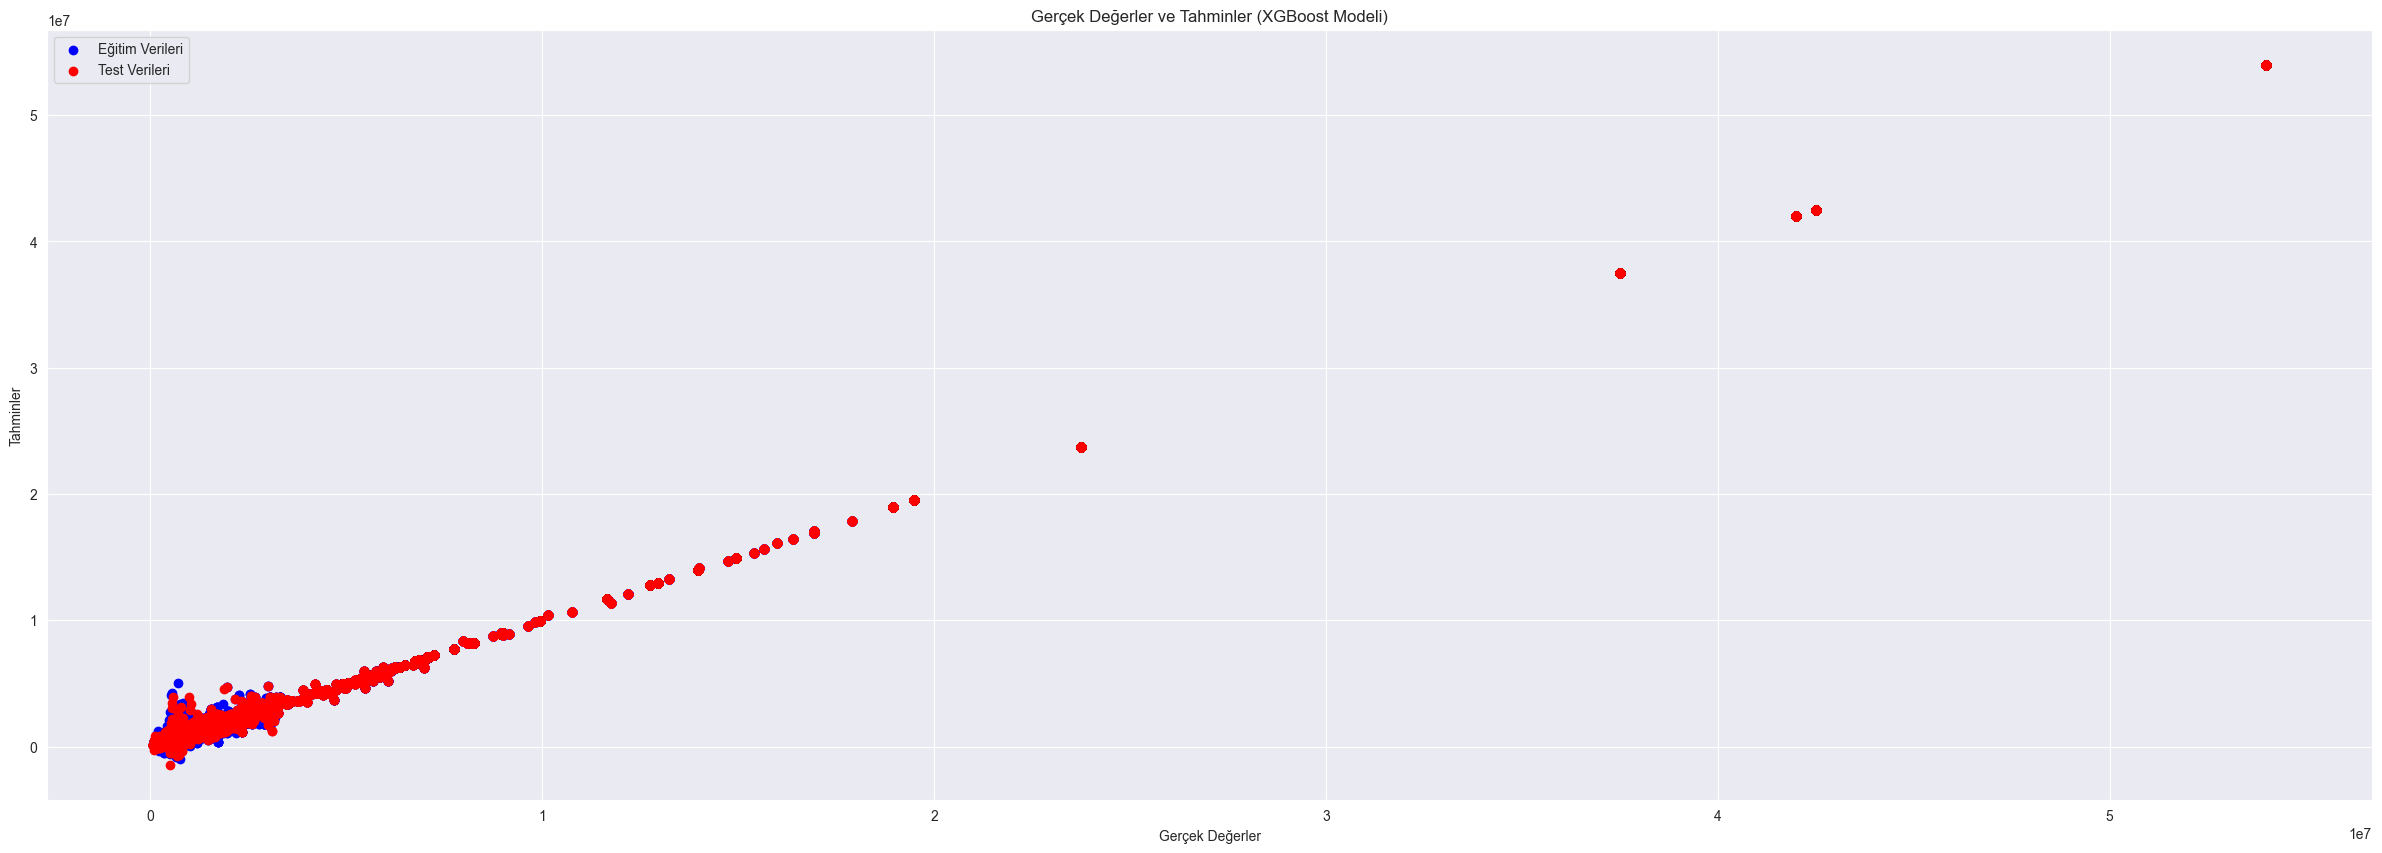

In [44]:

plt.figure(figsize=(30, 10))

plt.scatter(y_train_kf, train_predictions_xgb, color='blue', label='Eğitim Verileri')
plt.scatter(y_val_kf, test_predictions_xgb, color='red', label='Test Verileri')

plt.title('Gerçek Değerler ve Tahminler (XGBoost Modeli)')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.legend()

plt.show()

In [45]:
# RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [46]:
train_predictions_rf = model_rf.predict(X_train)
test_predictions_rf = model_rf.predict(X_test)
train_rmse_rf = mean_squared_error(y_train, train_predictions_rf, squared=False)
test_rmse_rf = mean_squared_error(y_test, test_predictions_rf, squared=False)

print("Eğitim RMSE:", train_rmse_rf)
print("Test RMSE:", test_rmse_rf)

Eğitim RMSE: 45200.70398311435
Test RMSE: 34323.932697074226


/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
